In [89]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [90]:
import xarray as xr
import preprocess as pp
import util

import xskillscore as xs
from tqdm.autonotebook import tqdm  # Fancy progress bars for our loops!

import matplotlib.pyplot as plt
import numpy as np

In [91]:
plot_varnames = ["tas", "pr", "psl"]
timeslice = slice('1981', '2010')

### Load interim data

In [92]:
obs = xr.open_zarr("../data/interim/era5").load()
obs["nino34"] = obs["enso34"].std(dim='time', skipna=True)

In [93]:
ens_dict = {}
ens_av_dict = {}
ens_std_dict = {}
for key in pp.all_mip_ids:
    ens = xr.open_zarr(f"../data/interim/{key}").chunk({'lat': -1, 'lon':-1}).load()
    ens_dict[key] = ens
    ens_dict[key]["nino34"] = ens_dict[key]["enso34"].std(dim='time', skipna=True)
        
    if key=="far":
        ens_dict[key] = ens_dict[key].drop(["tas_clim", "pr_clim"])

### Compute magnitude of seasonal cycle

In [94]:
for key in ens_dict.keys():
    for dv in ens_dict[key].data_vars:
        if '_clim' in dv:
            clim = ens_dict[key][dv]
            ens_dict[key][dv.split("_")[0]+"_season"] = clim.sel(month=[6, 7, 8]).mean(dim='month') - clim.sel(month=[12, 1, 2]).mean(dim='month')
            
for dv in obs.data_vars:
    if '_clim' in dv:
        clim = obs[dv]
        obs[dv.split("_")[0]+"_season"] = clim.sel(month=[6, 7, 8]).mean(dim='month') - clim.sel(month=[12, 1, 2]).mean(dim='month')

/srv/conda/envs/cmip6hack-multigen/lib/python3.7/site-packages/xarray/core/nanops.py:140: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


### Quality control

In [95]:
# Continental temperatures 20ºC higher than other ensemble members...
ens_dict['cmip6'] = ens_dict['cmip6'].isel(ensemble = ens_dict['cmip6']['ensemble'] != 'NIMS-KMA-KACE-1-0-G-r3i1p1f1')

# Units seem to be wrong... even after using the correction on the first ensemble member
ens_dict['cmip6'] = ens_dict['cmip6'].isel(ensemble = ens_dict['cmip6']['ensemble'] != 'UA-MCM-UA-1-0-r1i1p1f2')

# Negative precipitation...
ens_dict['sar']['pr_mean'].loc[{'ensemble': 'HCCPR-HCCPR-01-r3i1p1f1'}] = np.nan

## Mean absolute error

In [102]:
obs_tmp

<xarray.Dataset>
Dimensions:    (lat: 90, lon: 180, month: 12, time: 360)
Coordinates:
  * lat        (lat) float64 -89.0 -87.0 -85.0 -83.0 ... 83.0 85.0 87.0 89.0
  * lon        (lon) float64 1.0 3.0 5.0 7.0 9.0 ... 353.0 355.0 357.0 359.0
  * month      (month) int64 1 2 3 4 5 6 7 8 9 10 11 12
  * time       (time) datetime64[ns] 1981-01-01 1981-02-01 ... 2010-12-01
Data variables:
    pr_mean    (lat, lon) float64 1.854e-06 1.849e-06 ... 8.038e-06 8.051e-06
    tas_mean   (lat, lon) float64 228.2 228.1 228.1 228.1 ... 259.1 259.1 259.1
    tas_trend  (lat, lon) float64 -8.162e-05 -8.139e-05 ... 4.589e-05 4.702e-05
    nino34     float64 0.9718

In [223]:
area = util.calc_area(obs.lat, obs.lon)

mae_varnames = ['tas_trend', 'tas_mean', 'tas_season', 'pr_mean', 'pr_season', 'psl_mean', 'psl_season']

mae_dict = {}
mae_av_dict = {}
mae_std_dict = {}
for key, ens in tqdm(ens_dict.items()):
    ens_tmp = ens.drop([var for var in list(ens.data_vars) if var not in mae_varnames])
    obs_tmp = obs.drop([var for var in list(obs.data_vars) if var not in list(ens_tmp.data_vars)])
    mae = xs.mae(
        obs_tmp.drop(["month", "time"]),
        ens_tmp.drop(["month", "time"]),
        ['lat', 'lon'], weights=area
    ).compute()
    mae['nino34'] = np.abs(ens['nino34'] - obs['nino34'])
    mae_dict[key] = mae
    mae_av_dict[key] = mae.groupby('source_id').mean(skipna=True)
    mae_std_dict[key] = mae.groupby('source_id').std(skipna=True).copy()

/srv/conda/envs/cmip6hack-multigen/lib/python3.7/site-packages/xarray/core/nanops.py:140: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


In [224]:
# CMIP6 median
mae_med = mae_av_dict['cmip6'].sel(source_id=[key for key in mae_dict['cmip6'].source_id.values if key!='ens-mean']).median(dim='source_id', skipna=True).compute()

mae_skill_score_dict = {}
mae_std_skill_score_dict = {}
for key, mae in mae_av_dict.items():
    mae_skill_score_dict[key] = (mae/mae_med)
    mae_std_skill_score_dict[key] = (mae_std_dict[key]/mae_med)

In [225]:
performance_weights = {
    'tas_mean': 1./9.,
    'pr_mean': 1./9.,
    'psl_mean': 1./9.,
    'tas_season': 1./9.,
    'pr_season': 1./9.,
    'psl_season': 1./9.,
    'tas_trend': 1./3.,
}

for key, mae_ss in mae_skill_score_dict.items():
    da = xr.concat([mae_ss[d] for d in mae_ss.data_vars if 'nino34' not in d], dim='metric')
    da.name = "performance"
    da = da.assign_coords({'metric': [d for d in mae_ss.data_vars if 'nino34' not in d]})
    da['weights'] = xr.DataArray([performance_weights[d] for d in mae_ss.data_vars if 'nino34' not in d], dims='metric')
    da['performance'] = (da * da['weights']).sum(dim='metric') / ((~np.isnan(da)) * da['weights']).sum(dim='metric')
    
    mae_skill_score_dict[key]['performance'] = da['performance']
    mae_std_skill_score_dict[key]['performance'] = da['performance']*0.

# Skill metrics over time

In [226]:
mip_year_dict = {'far': 1990,
                 'sar': 1996,
                 'tar': 2000,
                 'cmip3': 2005,
                 'cmip5': 2013,
                 'cmip6': 2019}

mip_col = {'far': 'C5',
           'sar': 'C4',
           'tar': 'C3',
           'cmip3': 'C2',
           'cmip5': 'C1',
           'cmip6': 'C0'}

var_shape = {'tas_mean': 'o', 'pr_mean': 's', 'psl_mean': 'D', 'tas_season': 'v', 'pr_season': '<', 'psl_season': '>', 'tas_trend': 'p', 'nino34': 'P', 'performance': 'H'}

### Correlations

(0.5, 1.5)

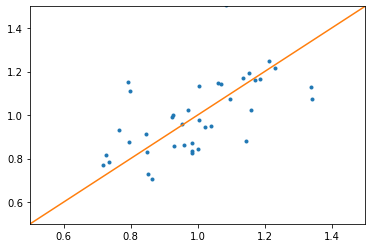

In [248]:
plt.plot(mae_skill_score_dict['cmip6']['pr_mean'], mae_skill_score_dict['cmip6']['tas_mean'], ".")
plt.plot([0, 2], [0, 2])
plt.xlim([0.5, 1.5])
plt.ylim([0.5, 1.5])

(0.5, 1.5)

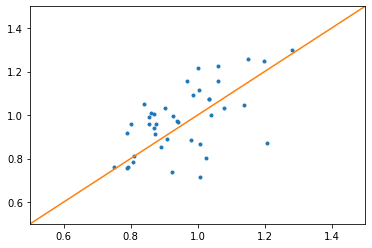

In [246]:
plt.plot(mae_skill_score_dict['cmip6']['pr_season'], mae_skill_score_dict['cmip6']['tas_season'], ".")
plt.plot([0, 2], [0, 2])
plt.xlim([0.5, 1.5])
plt.ylim([0.5, 1.5])

(0.5, 1.5)

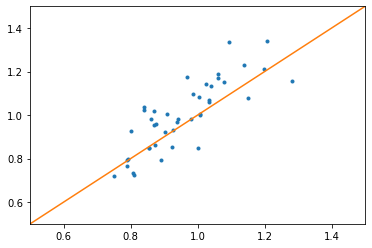

In [242]:
plt.plot(mae_skill_score_dict['cmip6']['pr_season'], mae_skill_score_dict['cmip6']['pr_mean'], ".")
plt.plot([0, 2], [0, 2])
plt.xlim([0.5, 1.5])
plt.ylim([0.5, 1.5])

### Find outliers

In [74]:
mae_dict['cmip6']['tas_trend'].argmax()

<xarray.DataArray 'tas_trend' ()>
array(114)
Coordinates:
    mip_id   <U4 'CMIP'

In [75]:
mae_dict['cmip6'].ensemble.values[114]

'E3SM-Project-E3SM-1-1-ECA-r1i1p1f1'

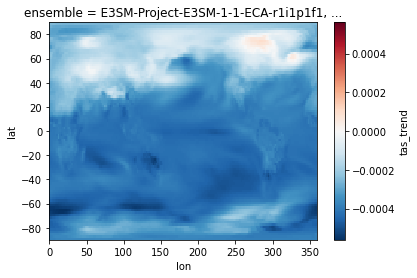

In [76]:
ens_dict['cmip6']['tas_trend'].sel(ensemble='E3SM-Project-E3SM-1-1-ECA-r1i1p1f1').plot()

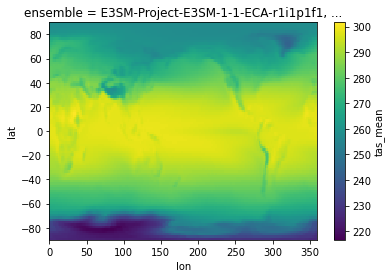

In [77]:
ens_dict['cmip6']['tas_mean'].sel(ensemble='E3SM-Project-E3SM-1-1-ECA-r1i1p1f1').plot()

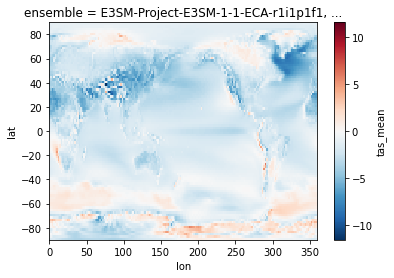

In [78]:
(ens_dict['cmip6']['tas_mean'].sel(ensemble='E3SM-Project-E3SM-1-1-ECA-r1i1p1f1') - obs['tas_mean']).plot()

In [ ]:
fig, axes = plt.subplots(len(plot_varnames),1,figsize=(8,12))

ax=axes[0]
ens_mean_label = "ens-mean"
ax.plot([], [], 'k<', markersize=10, label=ens_mean_label)
ax.plot([], [], 'k>', markersize=10, label='ens-median')

ax.plot([], [], 'k', marker=var_shape['tas'], markersize=10, label='tas', linewidth=0.)
ax.plot([], [], 'k', marker=var_shape['pr'], markersize=10, label='pr', linewidth=0.)
ax.plot([], [], 'k', marker=var_shape['psl'], markersize=10, label='sfcWind', linewidth=0.)

for key, ens in ens_dict.items():
    
    subplot_count = 1
    for idx, var_key in enumerate(var_shape.keys()):
        
        if var_key not in mae_dict[key]: continue
        
        if var_key == 'tas':
            ens_label = key
        else:
            ens_label = None
            
        ax = axes[idx]
        
        data = mae_skill_score_dict[key][var_key]
        data = data[~np.isnan(data)]
        
        alpha=0.75
        markersize=15.
        if data.size > 10:
            alpha=0.4
            markersize=10
            
        ax.plot(
            data,mip_year_dict[key]*np.ones_like(data),
            linewidth=0, marker=".", markersize=markersize, alpha=alpha, color="C0"
        )
        
        if data.size > 10:
            parts = ax.violinplot(
                data[~np.isnan(data)],
                positions=[mip_year_dict[key]],
                widths = 5.,
                vert=False, showextrema=False,
            )

            for pc in parts['bodies']:
                pc.set_facecolor("C0")
                pc.set_edgecolor("k")
                pc.set_alpha(0.3)

        subplot_count+=1
    
var_longname = ['near-surface air temperature', 'precipitation rate', 'sea level pressure']
var_minlim = [0.0, 0.0, 0.0]
var_maxlim = [3.5, 3.5, 3.5]
for subplot_count, ax in enumerate(axes):

    ax.set_ylim([1985,2025])
    ax.set_xlim([var_minlim[subplot_count], var_maxlim[subplot_count]])
    ax.set_ylabel('publication date')
    ax.set_xlabel('normalized model mean absolute error')
    if subplot_count == 0: ax.legend()
    ax.set_title(var_longname[subplot_count]+' performance')
    ax.grid(True)
    
plt.tight_layout()
plt.savefig("../figures/model_performance_over_time_violin.png",bbox_inches='tight',dpi=100)

In [66]:
mip = 'cmip6'
percent_spread = (mae_dict[mip].groupby('source_id').max() - mae_dict[mip].groupby('source_id').min())/mae_dict[mip].groupby('source_id').mean(skipna=True).compute()
for dv in percent_spread.data_vars:
    percent_spread[dv].loc[percent_spread[dv]==0.] = np.nan

/srv/conda/envs/cmip6hack-multigen/lib/python3.7/site-packages/xarray/core/nanops.py:140: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


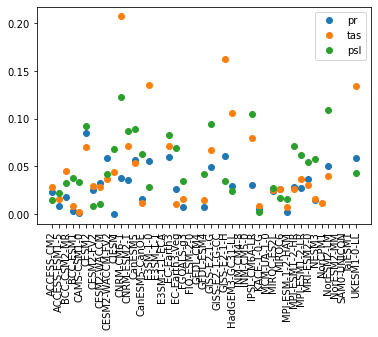

In [67]:
plt.plot(percent_spread['pr_mean'].values, "o", label='pr')
plt.plot(percent_spread['tas_mean'].values, "o", label='tas')
plt.plot(percent_spread['psl_mean'].values, "o", label='psl')
plt.xticks(np.arange(0, len(percent_spread.source_id.values)), percent_spread.source_id.values, rotation=90)
plt.legend()

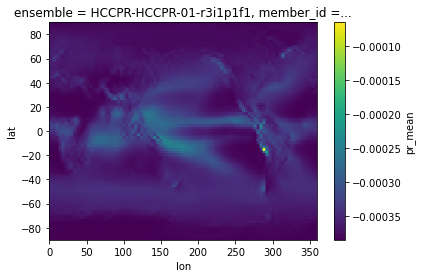

In [27]:
q = (ens_dict['sar'].sel(ensemble='HCCPR-HCCPR-01-r3i1p1f1')['pr_mean']).plot()
#q.set_clim([0., 1.e-4])

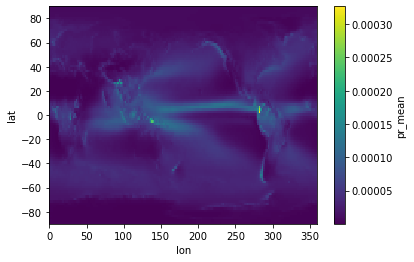

In [19]:
q = obs['pr_mean'].plot()
q.set_clim([0., 1.e-4])

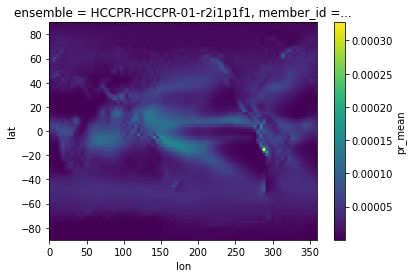

In [18]:
q = ens_dict['sar'].sel(ensemble='HCCPR-HCCPR-01-r2i1p1f1')['pr_mean'].plot()
q.set_clim([0., 1.e-4])

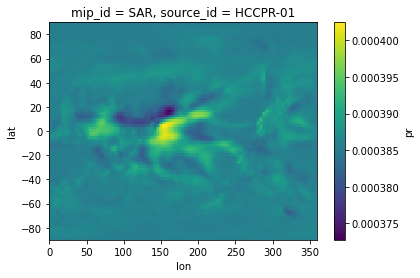

In [65]:
(ens_dict['sar'].sel(ensemble='HCCPR-HCCPR-01-r2i1p1f1')['pr'] - ens_dict['sar'].sel(ensemble='HCCPR-HCCPR-01-r3i1p1f1')['pr']).plot()